In [1]:
!pip install --upgrade tensorflow

In [100]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from keras.models import Model
import tensorflow.keras.layers as tfl
from keras.preprocessing import image
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.applications.inception_v3 import InceptionV3

In [3]:
tf.__version__

'2.10.0'

In [109]:
DATA_DIR = "../input/asian-vs-african-elephant-image-classification/dataset/"
os.listdir(DATA_DIR)

['test', 'train']

In [110]:
TRAIN_DATA_EL = DATA_DIR+"train/"

In [111]:
BATCH_SIZE = 64
IMG_SIZE = (160, 160)
directory = TRAIN_DATA_EL
train_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='training',
                                             seed=42)
validation_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='validation',
                                             seed=42)

Found 840 files belonging to 2 classes.
Using 672 files for training.
Found 840 files belonging to 2 classes.
Using 168 files for validation.


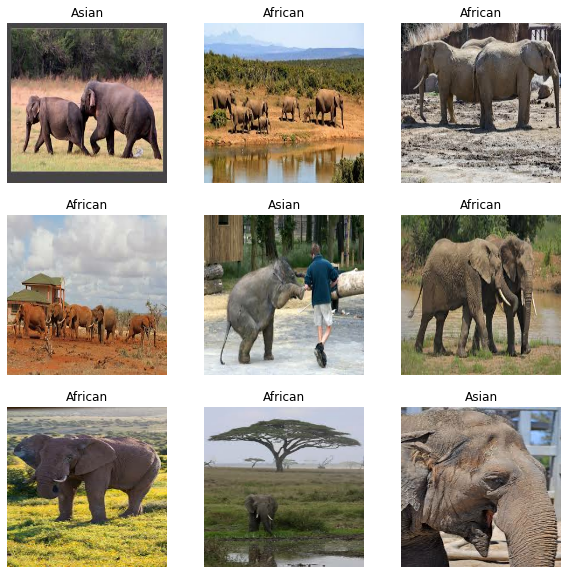

In [112]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

# Subtle difference between two breeds
The Africans tend to have more rounded heads and Asian ones have a more twin domed heads. The African ones also tend to be bigger in size. We want our model to pick up on mainly these difference in these shapes of head and ignore other irrelevant signals such as background scenary etc.

In [113]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

In [114]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [115]:
def elephant_model(image_shape=IMG_SIZE):
    ''' Define a tf.keras model for binary classification out of the MobileNetV2 model
    Arguments:
        image_shape -- Image width and height
        data_augmentation -- data augmentation function
    Returns:
    Returns:
        tf.keras.model
    '''
    inp = tfl.Input((160, 160, 3))
    inception = InceptionV3(include_top=False, weights='imagenet', input_tensor=inp, input_shape=(160, 160, 3), pooling='avg')
    x = inception.output
    x = tfl.Dense(256, activation='relu')(x)
    x = tfl.Dropout(0.1)(x)
    out = tfl.Dense(1, activation='softmax')(x)

    complete_model = Model(inp, out)
    return complete_model
    
    
    
#     input_shape = image_shape + (3,)
    
#     base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(
#     input_shape=input_shape,
#     include_top=False,
#     weights='imagenet',
#     classifier_activation=None 
#     )
    
#     base_model.trainable = False
#     inputs = tf.keras.Input(input_shape)
#     #print(base_model.summary())
#     #X = data_augmentation(inputs)
    
#     X = preprocess_input(inputs)
#     X = base_model(X, training=False)
    
#     X = tfl.GlobalAveragePooling2D()(X)
#     X = tfl.Dropout(0.2)(X)
    
#     prediction_layer = tfl.Dense(1)
    
#     outputs = prediction_layer(X) 
#     model = tf.keras.Model(inputs, outputs)
#     return model

In [116]:
model = elephant_model(IMG_SIZE)

87910968/87910968 [==============================] - 1s 0us/step


In [117]:
base_learning_rate = 0.01
# model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
#               loss=tf.keras.losses.BinaryCrossentropy(),
#               metrics=['accuracy'])
model.compile(optimizer='adam', loss='binary_crossentropy')

In [119]:
initial_epochs = 1
history = model.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs)

11/11 [==============================] - 88s 8s/step - loss: 0.7045 - val_loss: 84066.1797


In [125]:
history.history.keys()

dict_keys(['loss', 'val_loss'])

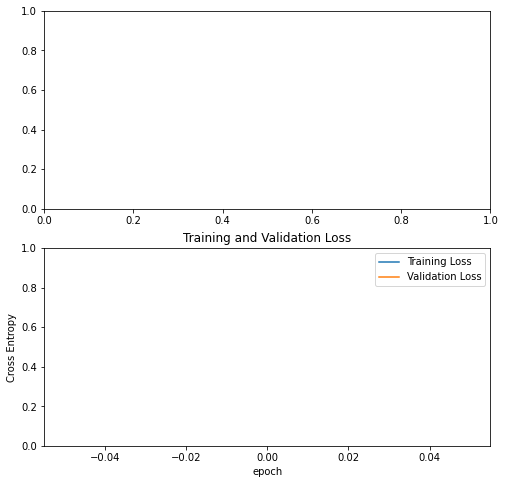

In [126]:
# acc = [0.] + history.history['accuracy']
# val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
# plt.plot(acc, label='Training Accuracy')
# plt.plot(val_acc, label='Validation Accuracy')
# plt.legend(loc='lower right')
# plt.ylabel('Accuracy')
# plt.ylim([min(plt.ylim()),1])
# plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [121]:
model.summary()

Model: "model_27"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 79, 79, 32)   864         ['input_14[0][0]']               
                                                                                                  
 batch_normalization (BatchNorm  (None, 79, 79, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                           

In [127]:
# Taking the outputs of first 100 layers from trained model, leaving the first Input layer, in a list
layer_outputs = [layer.output for layer in model.layers[1:100]]

# This is image of a Rose flower from our dataset. All of the visualizations in this cell are of this image.
test_image = "../input/asian-vs-african-elephant-image-classification/dataset/train/Asian/as_tr105.jpg"
# Loading the image and converting it to a numpy array for feeding it to the model. Its important to use expand_dims since our original model takes batches of images
# as input, and here we are feeding a single image to it, so the number of dimensions should match for model input.
img = tf.keras.utils.load_img(test_image, target_size=(160, 160))
img_arr = tf.keras.utils.img_to_array(img)
img_arr = tf.expand_dims(img_arr, 0) # Create a batch


# Defining a new model using original model's input and all the 100 layers outputs and then predicting the values for all those 100 layers for our test image.
activation_model = tf.keras.Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(img_arr)

# These are names of layers, the outputs of which we are going to visualize.
layer_names = ['conv2d_1', 'activation_1', 'conv2d_4', 'activation_4', 'conv2d_9', 'activation_9']
activ_list = [activations[0], activations[2], activations[10], activations[12], activations[17], activations[19]]

1/1 [==============================] - 1s 669ms/step


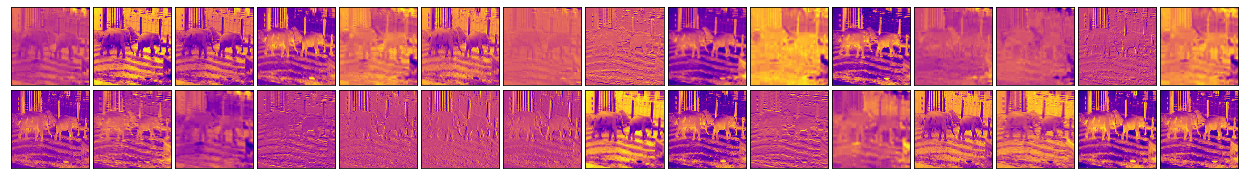

In [128]:
fig = plt.figure(figsize=(22, 3))
for img in range(30):
    ax = fig.add_subplot(2, 15, img+1)
    ax = plt.imshow(activations[0][0, :, :, img], cmap='plasma')
    plt.xticks([])
    plt.yticks([])
    fig.subplots_adjust(wspace=0.05, hspace=0.05)